### Context

To minimize loss from the bank’s perspective, the bank needs a decision rule regarding whom to approve the loan and whom not to. An applicant’s demographic and socio-economic profiles are considered by loan managers before a decision is taken regarding his/her loan application.
In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as a good or bad credit risk according to the set of attributes. 
 

### Objective:
The objective is to build a predictive model on this data to help the bank decide on whether to approve a loan to a prospective applicant.

 
### Dataset:
- Age (Numeric: Age in years)
- Sex (Categories: male, female)
- Job (Categories: unskilled and non-resident, unskilled and resident, skilled, highly skilled)
- Housing (Categories: own, rent, or free)
- Saving accounts (Categories: little, moderate, quite rich, rich)
- Checking account (Categories: little, moderate, rich)
- Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
- Duration (Numeric: Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment,radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))

## Let's start by importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# import warnings

# warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# Library to split data
from sklearn.model_selection import train_test_split

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)


# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

<IPython.core.display.Javascript object>

## Load and overview the dataset

In [2]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
data = pd.read_csv("German_Credit.csv")

<IPython.core.display.Javascript object>

In [3]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
0,67,male,skilled,own,little,little,1169,6,0,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,1,radio/TV
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
3,45,male,skilled,free,little,little,7882,42,0,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,1,car


<IPython.core.display.Javascript object>

### Understand the shape of the dataset.

In [4]:
data.shape

(1000, 10)

<IPython.core.display.Javascript object>

### Check the data types of the columns in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


<IPython.core.display.Javascript object>

- There are total 10 columns and 1,000 observations in the dataset
- We have only three continuous variables - Age, Credit Amount, and Duration.
- All other variables are categorical
- We can see that there are no missing values in the dataset.

### Summary of the data

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
Risk,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


<IPython.core.display.Javascript object>

**Observations**

- Mean value for the age column is approx 35 and the median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range with values from 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.

In [7]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

male      690
female    310
Name: Sex, dtype: int64
----------------------------------------
skilled                       630
unskilled_and_non-resident    222
highly skilled                148
Name: Job, dtype: int64
----------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
----------------------------------------
little        786
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
----------------------------------------
moderate    472
little      465
rich         63
Name: Checking account, dtype: int64
----------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64
----------------------------------------
0    700
1    300
Name: Risk, dtype: int64
--------------------------------

<IPython.core.display.Javascript object>

- We have more male customers as compared to female customers
- There are very few observations i.e., only 22 for customers with job category - unskilled and non-resident
- We can see that the distribution of classes in the target variable is imbalanced i.e., only 30% observations with defaulters.
- Most of the customers are not at risk.

## Univariate analysis

In [8]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Observation on Age 

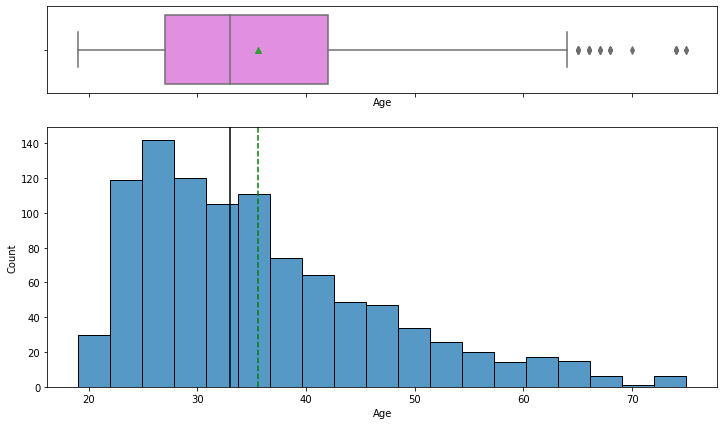

<IPython.core.display.Javascript object>

In [9]:
histogram_boxplot(data, "Age")

- The distribution of age is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observation on Credit Amount

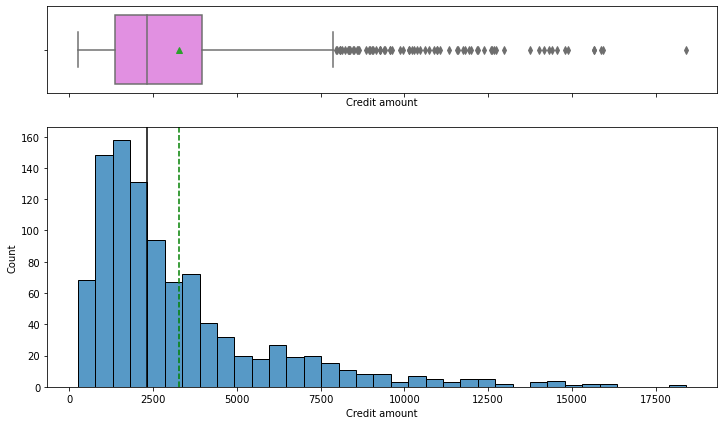

<IPython.core.display.Javascript object>

In [10]:
histogram_boxplot(data, "Credit amount")

- The distribution of the credit amount is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observations on Duration

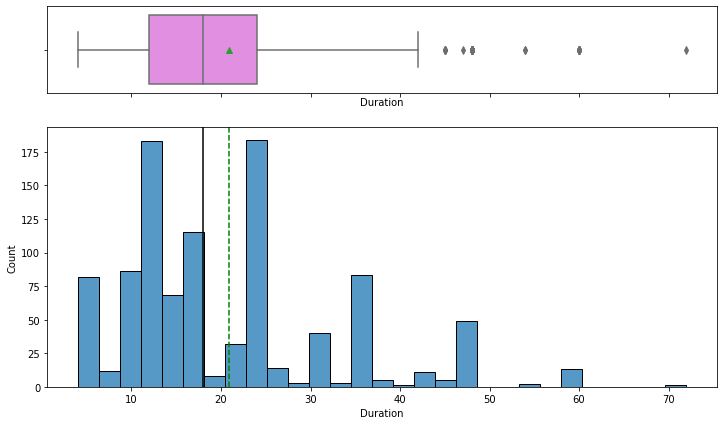

<IPython.core.display.Javascript object>

In [11]:
histogram_boxplot(data, "Duration")

- The distribution of the duration for which the credit is given is right-skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

In [12]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

### Observations on Risk

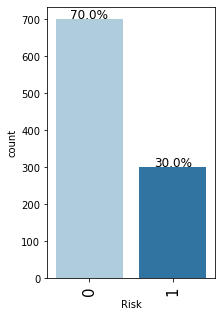

<IPython.core.display.Javascript object>

In [13]:
labeled_barplot(data, "Risk", perc=True)

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 70% observations for non-defaulters and 30% observations for defaulters.

### Observations on Sex of Customers

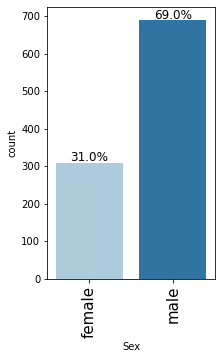

<IPython.core.display.Javascript object>

In [14]:
labeled_barplot(data, "Sex", perc=True)

- Male customers are taking more credit than female customers
- There are 69% male customers and 31% female customers

### Observations on Housing

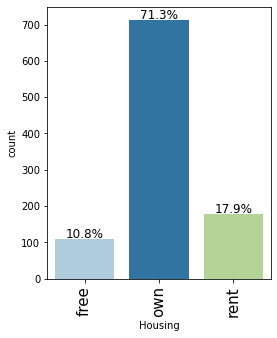

<IPython.core.display.Javascript object>

In [15]:
labeled_barplot(data, "Housing", perc=True)

- Major of the customers, approx 71%, who take credit have their own house
- Approx 18% customers are living in a rented house
- There are only 11% customers who have free housing. These are the customers who live in a house given by their company or organization

### Observations on Job

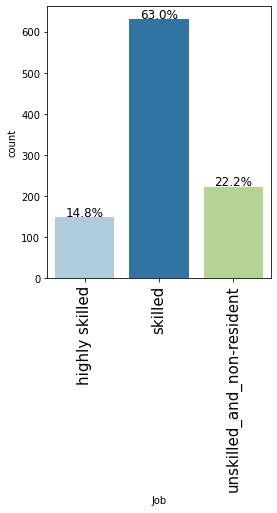

<IPython.core.display.Javascript object>

In [16]:
labeled_barplot(data, "Job", perc=True)

- Majority of the customers i.e. 63% fall into the skilled category.
- There are only approx 15% customers that lie in highly skilled category which makes sense as these may be the persons with high education or highly experienced.
- There are very few observations, approx 22%, with 0 or 1 job category.

### Observations on Saving accounts

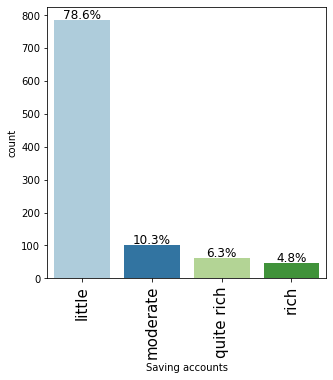

<IPython.core.display.Javascript object>

In [17]:
labeled_barplot(data, "Saving accounts", perc=True)

- Approx 70% customers who take credit have a little or moderate amount in their savings account. This makes sense as these customers would need credit more than the other categories.
- Approx 11% customers who take credit are in the rich category based on their balance in the savings account.
- Note that the percentages do not add up to 100 as we have missing values in this column.

### Observations on Checking account

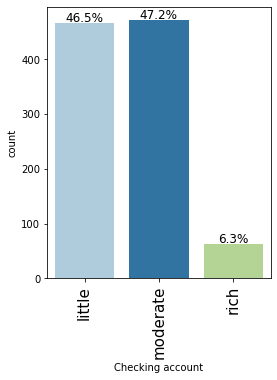

<IPython.core.display.Javascript object>

In [18]:
labeled_barplot(data, "Checking account", perc=True)

- Approx 47% customers who take credit have a little or moderate amount in their checking account. This makes sense as these customers would need credit more than the other categories.
- Approx 6% customers who take credit are in the rich category based on their balance in the checking account.

### Observations on Purpose

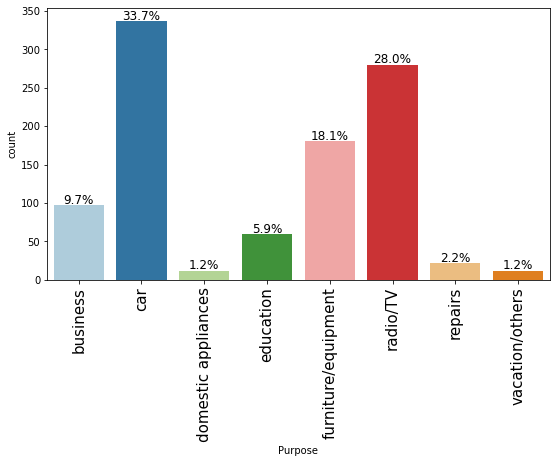

<IPython.core.display.Javascript object>

In [19]:
labeled_barplot(data, "Purpose", perc=True)

- The plot shows that most customers take credit for luxury items like car, radio or furniture/equipment, domestic appliances.
- Approximately just 16% customers take credit for business or education

## Bivariate Analysis

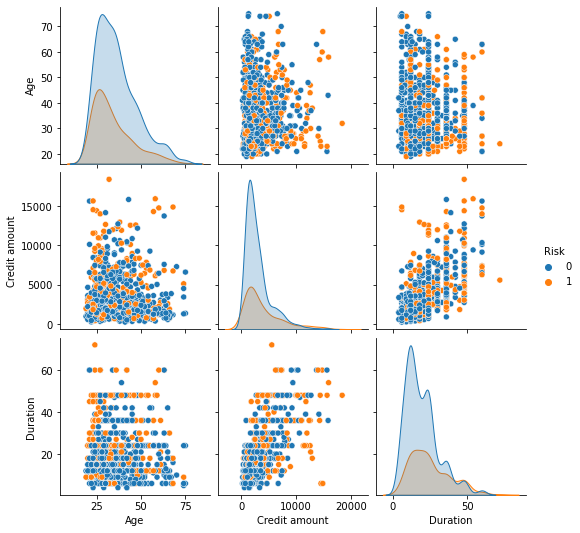

<IPython.core.display.Javascript object>

In [20]:
sns.pairplot(data, hue="Risk")
plt.show()

- There are overlaps i.e., no clear distinction in the distribution of variables for people who have defaulted and did not default.
- Let's explore this further with the help of other plots.

In [21]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

### Risk vs Age

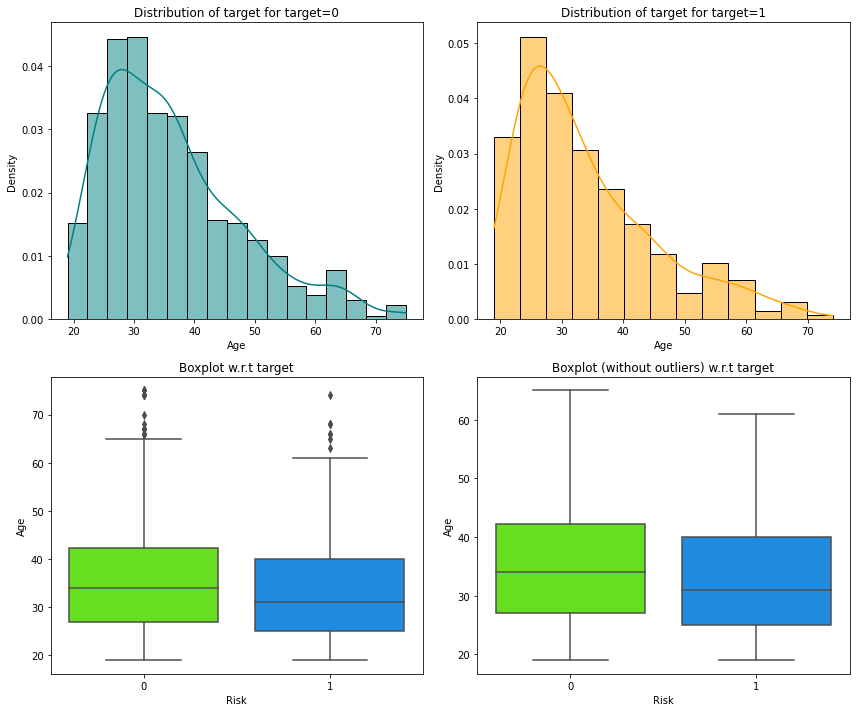

<IPython.core.display.Javascript object>

In [22]:
distribution_plot_wrt_target(data, "Age", "Risk")

- We can see that the median age of defaulters is less than the median age of non-defaulters.
- This shows that younger customers are more likely to default.
- There are outliers in boxplots of both class distributions

### Risk vs Credit amount

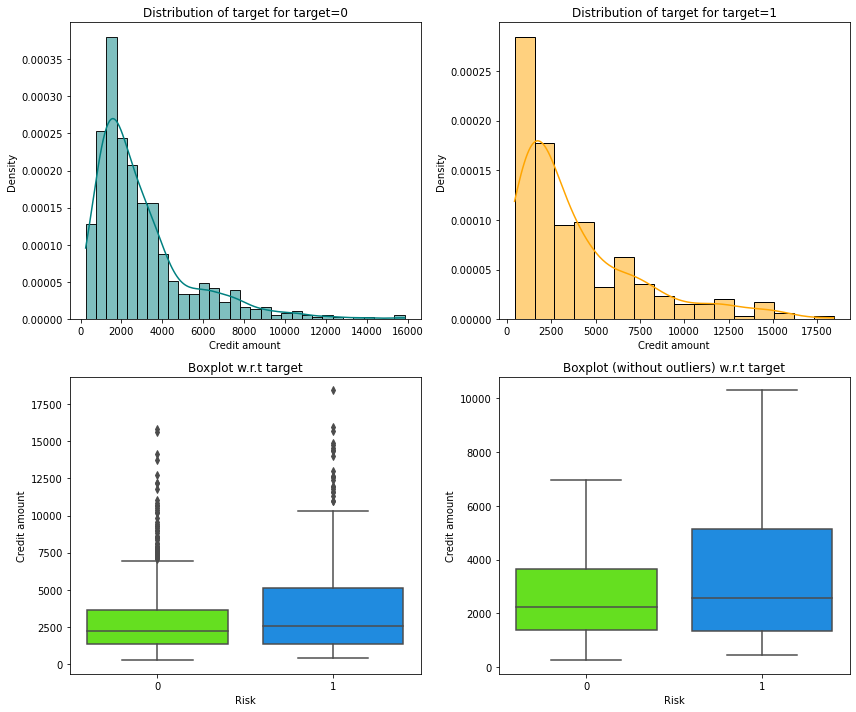

<IPython.core.display.Javascript object>

In [23]:
distribution_plot_wrt_target(data, "Credit amount", "Risk")

- We can see that the third quartile amount of defaulters is much more than the third quartile amount of non-defaulters.
- This shows that customers with high credit amount are more likely to default.
- There are outliers in boxplots of both class distributions

### Risk vs Duration

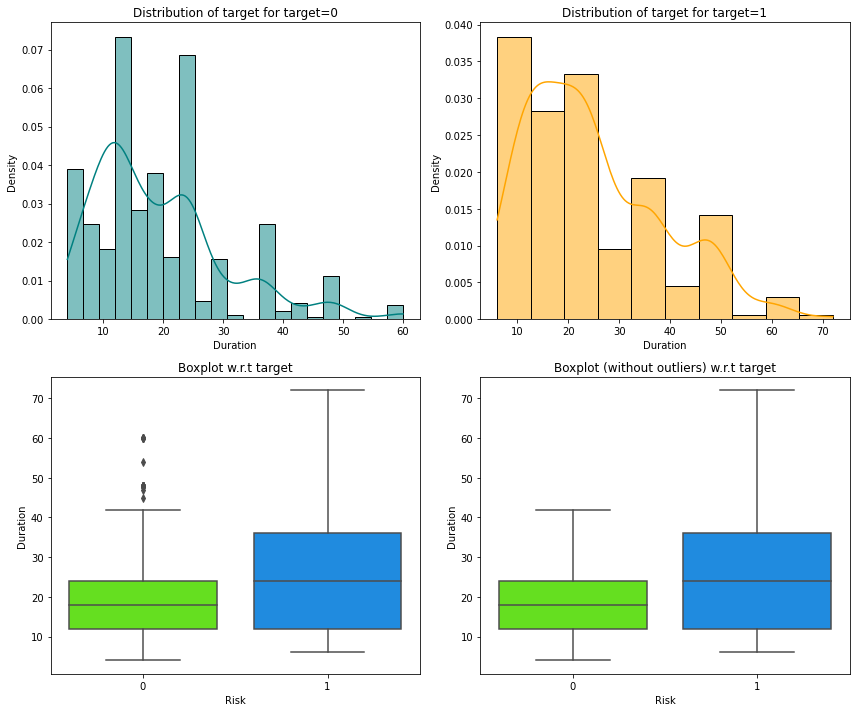

<IPython.core.display.Javascript object>

In [24]:
distribution_plot_wrt_target(data, "Duration", "Risk")

- We can see that the second and third quartiles of duration of defaulters is much more than the second and third quartiles duration of non-defaulters.
- This shows that customers with high duration are more likely to default.

In [25]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

### Risk vs Sex

Risk      0    1   All
Sex                   
All     700  300  1000
male    499  191   690
female  201  109   310
------------------------------------------------------------------------------------------------------------------------


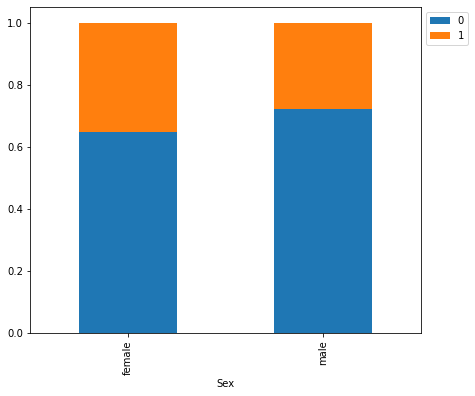

<IPython.core.display.Javascript object>

In [26]:
stacked_barplot(data, "Sex", "Risk")

- We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.

### Risk vs Job

Risk                          0    1   All
Job                                       
All                         700  300  1000
skilled                     444  186   630
unskilled_and_non-resident  159   63   222
highly skilled               97   51   148
------------------------------------------------------------------------------------------------------------------------


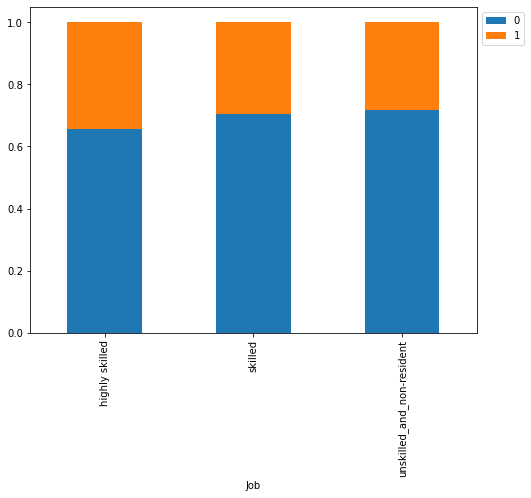

<IPython.core.display.Javascript object>

In [27]:
stacked_barplot(data, "Job", "Risk")

- There are no significant difference with respect to the job level
- However, highly skilled or unskilled/non-resident customers are more likely to default as compared to customers in 1 or 2 category 

### Risk vs Housing

Risk       0    1   All
Housing                
All      700  300  1000
own      527  186   713
rent     109   70   179
free      64   44   108
------------------------------------------------------------------------------------------------------------------------


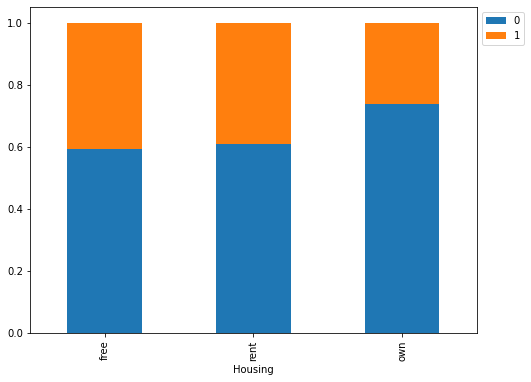

<IPython.core.display.Javascript object>

In [28]:
stacked_barplot(data, "Housing", "Risk")

- Customers owning a house are less likely to default
- Customers with free or rented housing are almost at same risk of default

### Risk vs Saving accounts

Risk               0    1   All
Saving accounts                
All              700  300  1000
little           537  249   786
moderate          69   34   103
quite rich        52   11    63
rich              42    6    48
------------------------------------------------------------------------------------------------------------------------


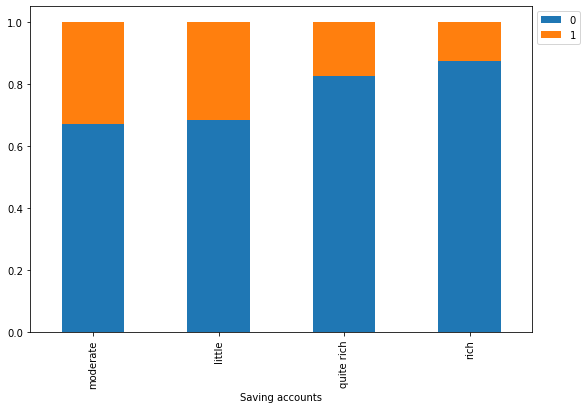

<IPython.core.display.Javascript object>

In [29]:
stacked_barplot(data, "Saving accounts", "Risk")

- Customers with little or moderate amounts in saving accounts are more likely to default.
- Rich customers are slightly less likely to default as compared to quite rich customers

### Risk vs Checking account

Risk                0    1   All
Checking account                
All               700  300  1000
little            304  161   465
moderate          347  125   472
rich               49   14    63
------------------------------------------------------------------------------------------------------------------------


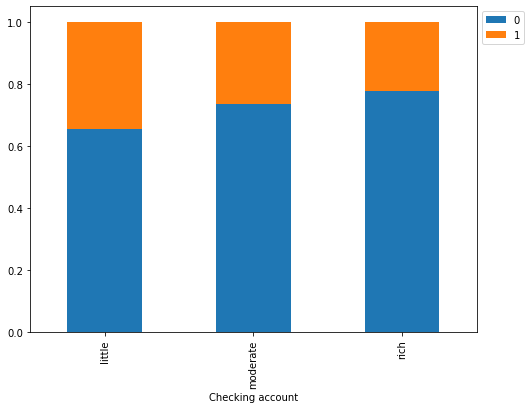

<IPython.core.display.Javascript object>

In [30]:
stacked_barplot(data, "Checking account", "Risk")

- The plot further confirms the findings of the previous plot.
- Customers with little amount in checking accounts are most likely to default as compared to customers with moderate amount, which in turn, are more likely as compared to the rich customers.

### Risk vs Purpose

Risk                   0    1   All
Purpose                            
All                  700  300  1000
car                  231  106   337
radio/TV             218   62   280
furniture/equipment  123   58   181
business              63   34    97
education             36   23    59
repairs               14    8    22
vacation/others        7    5    12
domestic appliances    8    4    12
------------------------------------------------------------------------------------------------------------------------


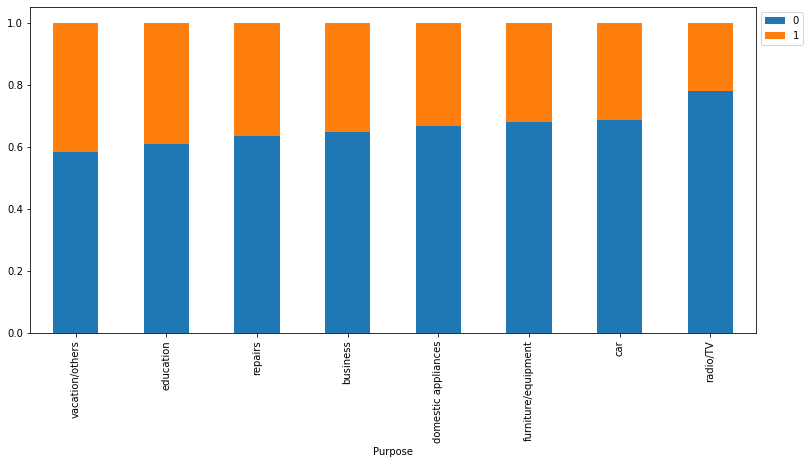

<IPython.core.display.Javascript object>

In [31]:
stacked_barplot(data, "Purpose", "Risk")

- Customers who take credit for radio/TV are least likely to default. This might be because their credit amount is small.
- Customers who take credit for education or vacation are most likely to default.
- Other categories have no significant difference between their default and non-default ratio.

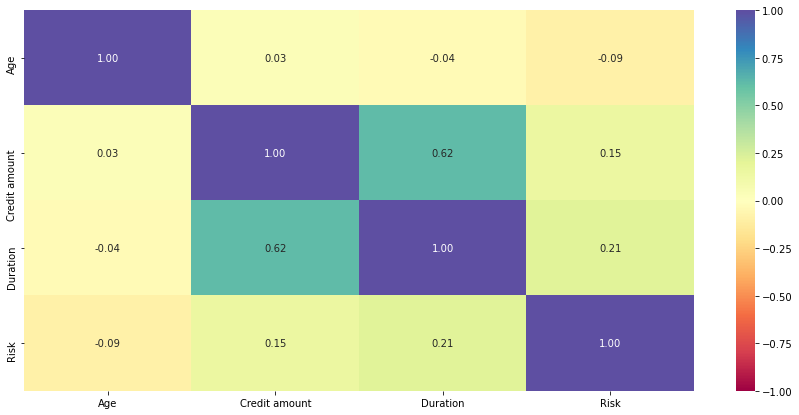

<IPython.core.display.Javascript object>

In [32]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- Credit amount and duration have positive correlation which makes sense as customers might take the credit for longer duration if the amount of credit is high.
- Other variables have no significant correlation between them.

### Model evaluation criterion

### Model can make wrong predictions as:

1. Model predicted a non-defaulter as a defaulter - False Positive
2. Model predicted a defaulter as a non-defaulter - False Negative

### How to reduce this loss i.e need to reduce False Negatives ?

* Company would want to reduce false negatives, this can be done by maximizing the Recall. Greater the recall lesser the chances of false negatives.

#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_statsmodels function will be used to check the model performance of models. 
* The confusion_matrix_statsmodels function will be used to plot confusion matrix.

In [33]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [34]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Data Preparation

In [35]:
# Converting monthly values to yearly
data["Duration"] = data["Duration"] / 12

<IPython.core.display.Javascript object>

In [36]:
X = data.drop("Risk", axis=1)
Y = data["Risk"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

<IPython.core.display.Javascript object>

### Logistic Regression (with statsmodels library)

In [37]:
X = data.drop("Risk", axis=1)
Y = data["Risk"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

# adding constant
X = sm.add_constant(X)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

<IPython.core.display.Javascript object>

In [38]:
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(
    disp=False
)  # setting disp=False will remove the information on number of iterations

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      679
Method:                           MLE   Df Model:                           20
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                 0.09777
Time:                        13:49:43   Log-Likelihood:                -388.81
converged:                       True   LL-Null:                       -430.94
Covariance Type:            nonrobust   LLR p-value:                 7.315e-10
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.4068      0.684      0.595      0.552      -0.934       1.747
Age                               -0.0220      0.009     -2.516      0.

<IPython.core.display.Javascript object>

In [39]:
X_train

,const,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
731,1.0,21,1987,2.000000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
716,1.0,40,3077,2.500000,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
640,1.0,27,750,1.500000,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
804,1.0,24,7472,1.000000,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0
737,1.0,35,4380,1.500000,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1.0,31,2901,0.833333,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
72,1.0,51,1164,0.666667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
908,1.0,46,3594,1.250000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
235,1.0,30,1823,2.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


<IPython.core.display.Javascript object>

**Observations**

- Negative values of the coefficient shows that probability of customer being a defaulter decreases with the increase of corresponding attribute value.

- Positive values of the coefficient show that that probability of customer being a defaulter increases with the increase of corresponding attribute value.

- p-value of a variable indicates if the variable is significant or not. If we consider the significance level to be 0.05 (5%), then any variable with a p-value less than 0.05 would be considered significant.

- But these variables might contain multicollinearity, which will affect the p-values.

* We will have to remove multicollinearity from the data to get reliable coefficients and p-values.

* There are different ways of detecting (or testing) multi-collinearity, one such way is the Variation Inflation Factor.

### Additional Information on VIF

* **Variance  Inflation  factor**:  Variance  inflation  factors  measure  the  inflation  in  the variances of the regression coefficients estimates due to collinearity that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient βk is "inflated" by  the  existence  of  correlation  among  the  predictor variables in the model. 

* General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity. But the purpose of the analysis should dictate which threshold to use. 

In [40]:
vif_series = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
)
print("Series before feature selection: \n\n{}\n".format(vif_series))

Series before feature selection: 

const                             63.161288
Age                                1.198164
Credit amount                      1.950358
Duration                           1.778746
Sex_male                           1.106317
Job_skilled                        2.227322
Job_unskilled_and_non-resident     2.231373
Housing_own                        2.564914
Housing_rent                       2.722881
Saving accounts_moderate           1.141051
Saving accounts_quite rich         1.078112
Saving accounts_rich               1.084254
Checking account_moderate          1.281717
Checking account_rich              1.099530
Purpose_car                        3.312477
Purpose_domestic appliances        1.155602
Purpose_education                  1.551275
Purpose_furniture/equipment        2.713083
Purpose_radio/TV                   3.087280
Purpose_repairs                    1.173268
Purpose_vacation/others            1.177324
dtype: float64



<IPython.core.display.Javascript object>

* None of the variables exhibit high multicollinearity, so the values in the summary are reliable.
* Let's remove the insignificant features (p-value>0.05).
* All the categorical levels of Job and Housing have a high p-value. Hence, these variables can be dropped at once.

**Dropping Job column**

In [41]:
X_train1 = X_train.drop(["Job_skilled", "Job_unskilled_and_non-resident"], axis=1,)

<IPython.core.display.Javascript object>

In [42]:
logit1 = sm.Logit(y_train, X_train1.astype(float))
lg1 = logit1.fit(disp=False)
print(lg1.summary())

                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                           18
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                 0.09695
Time:                        13:52:10   Log-Likelihood:                -389.16
converged:                       True   LL-Null:                       -430.94
Covariance Type:            nonrobust   LLR p-value:                 2.026e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.3433      0.637      0.539      0.590      -0.904       1.591
Age                            -0.0210      0.009     -2.431      0.015      -0.

<IPython.core.display.Javascript object>

**Dropping Housing column**

In [43]:
X_train2 = X_train1.drop(["Housing_own", "Housing_rent"], axis=1)

<IPython.core.display.Javascript object>

In [44]:
logit2 = sm.Logit(y_train, X_train2.astype(float))
lg2 = logit2.fit()
print(lg2.summary())

Optimization terminated successfully.
         Current function value: 0.561005
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      683
Method:                           MLE   Df Model:                           16
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                 0.08873
Time:                        13:53:11   Log-Likelihood:                -392.70
converged:                       True   LL-Null:                       -430.94
Covariance Type:            nonrobust   LLR p-value:                 7.146e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0382      0.467      0.082      0.935   

<IPython.core.display.Javascript object>

**Observations**

* Duration, BMI, Saving accounts_moderate, Saving accounts_quite_ rich, Checking account_rich, and many categorical levels of purpose have p-value > 0.05. So, they are not significant and we'll drop them.

* But sometimes p-values change after dropping a variable. So, we'll not drop all variables at once.

* Instead, we will do the following repeatedly using a loop:
  - Build a model, check the p-values of the variables, and drop the column with the highest p-value.
  - Create a new model without the dropped feature, check the p-values of the variables, and drop the column with the highest p-value.
  - Repeat the above two steps till there are no columns with p-value > 0.05.


The above process can also be done manually by picking one variable at a time that has a high p-value, dropping it, and building a model again. But that might be a little tedious and using a loop will be more efficient.

In [45]:
# initial list of columns
cols = X_train2.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    X_train_aux = X_train2[cols]

    # fitting the model
    model = sm.Logit(y_train, X_train_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['Age', 'Duration', 'Sex_male', 'Saving accounts_rich', 'Checking account_moderate', 'Purpose_radio/TV']


<IPython.core.display.Javascript object>

* The above columns are the significant column.
* We see that the loop has removed the constant also but we will need it to build the logistic regression model. So along with the significant variables we will keep the 'const' column as well.

In [46]:
# creating a new training set
X_train3 = X_train2[
    [
        "const",
        "Age",
        "Duration",
        "Sex_male",
        "Saving accounts_rich",
        "Checking account_moderate",
        "Purpose_radio/TV",
    ]
].astype(float)

<IPython.core.display.Javascript object>

In [47]:
logit3 = sm.Logit(y_train, X_train3)
lg3 = logit3.fit(disp=False)
print(lg3.summary())

                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                  700
Model:                          Logit   Df Residuals:                      693
Method:                           MLE   Df Model:                            6
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                 0.08245
Time:                        13:54:22   Log-Likelihood:                -395.41
converged:                       True   LL-Null:                       -430.94
Covariance Type:            nonrobust   LLR p-value:                 2.473e-13
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2803      0.336     -0.835      0.404      -0.938       0.378
Age                          -0.0212      0.008     -2.645      0.008      -0.037     

<IPython.core.display.Javascript object>

**Now no feature has p-value greater than 0.05, so we'll consider the features in *X_train3* as the final ones and *lg3* as final model.**

### Coefficient interpretations

* Coefficient of Duration is positive; an increase in these will lead to an increase in chances of a customer being a defaulter.
* Coefficients of Age, Sex_male, Savings account_rich, checking account_moderate, Purpose_radio/TV is negative; an increase in these will lead to a decrease in chances of a customer being a defaulter.

###  Converting coefficients to odds
* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [48]:
# converting coefficients to odds
odds = np.exp(lg3.params)

# finding the percentage change
perc_change_odds = (np.exp(lg3.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train3.columns).T

,const,Age,Duration,Sex_male,Saving accounts_rich,Checking account_moderate,Purpose_radio/TV
Odds,0.755573,0.979048,1.634190,0.640465,0.206045,0.649828,0.578734
Change_odd%,-24.442664,-2.095162,63.419002,-35.953451,-79.395501,-35.017190,-42.126573


<IPython.core.display.Javascript object>

### Coefficient interpretations

* `Age`: Holding all other features constant a unit change in Age will decrease the odds of a customer being a defaulter by 0.97 times or a 2.09% decrease in odds.
* `Duration`: Holding all other features constant a unit change in Duration will increase the odds of a customer being a defaulter by 1.63 times or a 63.41% increase in the odds.
* `Sex`: The odds of a male customer being a defaulter is 0.64 times less than a female customer or 35.95% fewer odds than female customers. [keeping Sex_female category as a reference]
* `Saving account`: The odds of a customer who has a Saving accounts_rich being a defaulter is 0.20 times less than a customer who has any other type of Savings account or 79.39% fewer odds than a customer with any other type of Savings account. [keeping all the other categorical levels of Savings account category as a reference]

`Interpretation for other attributes can be done similarly.`

#### Checking model performance on the training set

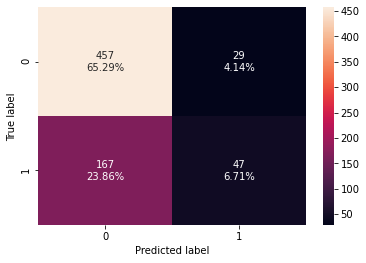

<IPython.core.display.Javascript object>

In [49]:
# creating confusion matrix
confusion_matrix_statsmodels(lg3, X_train3, y_train)

In [50]:
log_reg_model_train_perf = model_performance_classification_statsmodels(
    lg3, X_train3, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.72,0.219626,0.618421,0.324138


<IPython.core.display.Javascript object>

#### ROC-AUC

* ROC-AUC on training set

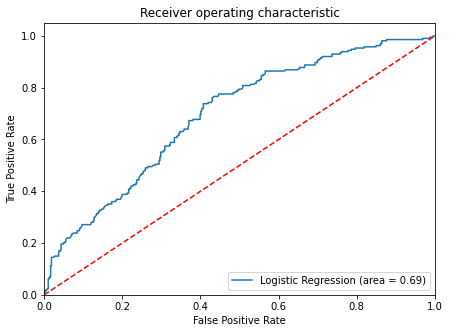

<IPython.core.display.Javascript object>

In [51]:
logit_roc_auc_train = roc_auc_score(y_train, lg3.predict(X_train3))
fpr, tpr, thresholds = roc_curve(y_train, lg3.predict(X_train3))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

* Logistic Regression model is a low recall and ROC-AUC score.

### Model Performance Improvement

* Let's see if the recall score can be improved further, by changing the model threshold using AUC-ROC Curve.

### Optimal threshold using AUC-ROC curve

In [52]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg3.predict(X_train3))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.27203829132658663


<IPython.core.display.Javascript object>

#### Checking model performance on training set

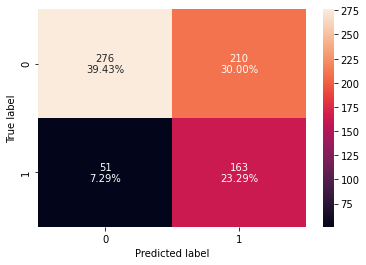

<IPython.core.display.Javascript object>

In [53]:
# creating confusion matrix
confusion_matrix_statsmodels(
    lg3, X_train3, y_train, threshold=optimal_threshold_auc_roc
)

In [54]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg3, X_train3, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.627143,0.761682,0.436997,0.555366


<IPython.core.display.Javascript object>

* Model performance has improved significantly.
* Model is giving a recall of 0.76 as compared to initial model which was giving a recall of 0.2. 
* Precision has decreased from 0.61 to 0.43.

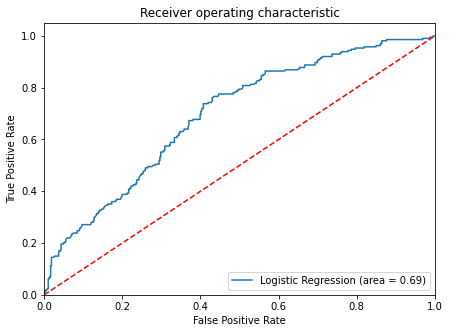

<IPython.core.display.Javascript object>

In [55]:
logit_roc_auc_train = roc_auc_score(y_train, lg3.predict(X_train3))
fpr, tpr, thresholds = roc_curve(y_train, lg3.predict(X_train3))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### Let's use Precision-Recall curve and see if we can find a better threshold

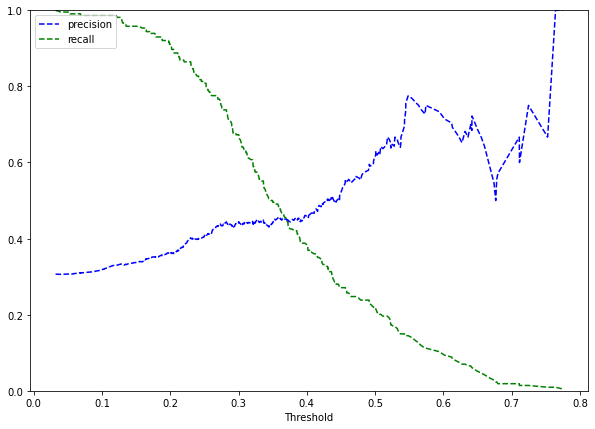

<IPython.core.display.Javascript object>

In [56]:
y_scores = lg3.predict(X_train3)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At threshold around 0.39 we will get equal precision and recall but taking a step back and selecting value around 0.36 will provide a higher recall and a good precision.

In [57]:
# setting the threshold
optimal_threshold_curve = 0.36

<IPython.core.display.Javascript object>

#### Checking model performance on training set

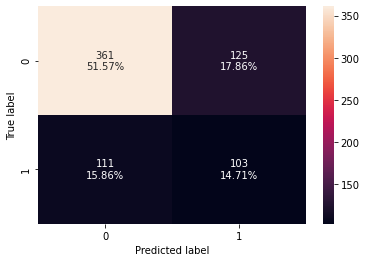

<IPython.core.display.Javascript object>

In [58]:
# creating confusion matrix
confusion_matrix_statsmodels(lg3, X_train3, y_train, threshold=optimal_threshold_curve)

In [59]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(
    lg3, X_train3, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.662857,0.481308,0.451754,0.466063


<IPython.core.display.Javascript object>

* Recall has improved as compared to the initial model.
* Model is giving a better performance with 0.27 threshold found using AUC-ROC curve.

### Model Performance Summary

In [60]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression statsmodel",
    "Logistic Regression-0.27 Threshold",
    "Logistic Regression-0.36 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression statsmodel,Logistic Regression-0.27 Threshold,Logistic Regression-0.36 Threshold
Accuracy,0.720000,0.627143,0.662857
Recall,0.219626,0.761682,0.481308
Precision,0.618421,0.436997,0.451754
F1,0.324138,0.555366,0.466063


<IPython.core.display.Javascript object>

### Let's check the performance on the test set

**Dropping the columns from the test set that were dropped from the training set**

In [61]:
X_test3 = X_test[X_train3.columns].astype(float)

<IPython.core.display.Javascript object>

**Using model with default threshold**

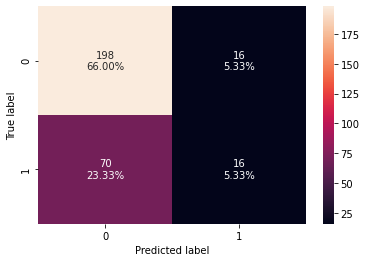

<IPython.core.display.Javascript object>

In [62]:
# creating confusion matrix
confusion_matrix_statsmodels(lg3, X_test3, y_test)

In [63]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
    lg3, X_test3, y_test
)

print("Test performance:")
log_reg_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.713333,0.186047,0.5,0.271186


<IPython.core.display.Javascript object>

* ROC curve on test set

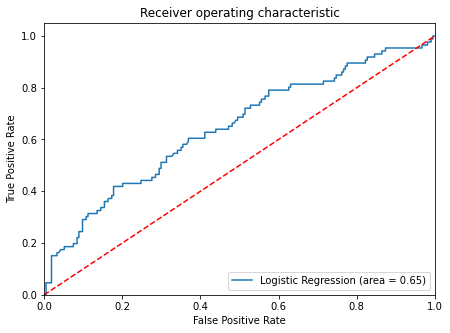

<IPython.core.display.Javascript object>

In [64]:
logit_roc_auc_train = roc_auc_score(y_test, lg3.predict(X_test3))
fpr, tpr, thresholds = roc_curve(y_test, lg3.predict(X_test3))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Using model with threshold=0.27** 

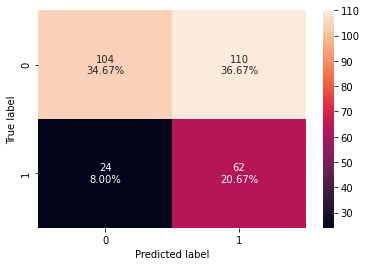

<IPython.core.display.Javascript object>

In [65]:
# creating confusion matrix
confusion_matrix_statsmodels(lg3, X_test3, y_test, threshold=optimal_threshold_auc_roc)

In [66]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg3, X_test3, y_test, threshold=optimal_threshold_auc_roc
)
print("Test performance:")
log_reg_model_test_perf_threshold_auc_roc

Test performance:


,Accuracy,Recall,Precision,F1
0,0.553333,0.72093,0.360465,0.48062


<IPython.core.display.Javascript object>

**Using model with threshold = 0.36**

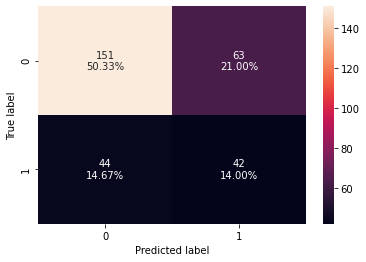

<IPython.core.display.Javascript object>

In [67]:
# creating confusion matrix
confusion_matrix_statsmodels(lg3, X_test3, y_test, threshold=optimal_threshold_curve)

In [68]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_statsmodels(
    lg3, X_test3, y_test, threshold=optimal_threshold_curve
)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


,Accuracy,Recall,Precision,F1
0,0.643333,0.488372,0.4,0.439791


<IPython.core.display.Javascript object>

### Model performance summary

In [69]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression statsmodel",
    "Logistic Regression-0.27 Threshold",
    "Logistic Regression-0.36 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression statsmodel,Logistic Regression-0.27 Threshold,Logistic Regression-0.36 Threshold
Accuracy,0.720000,0.627143,0.662857
Recall,0.219626,0.761682,0.481308
Precision,0.618421,0.436997,0.451754
F1,0.324138,0.555366,0.466063


<IPython.core.display.Javascript object>

In [70]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression statsmodel",
    "Logistic Regression-0.27 Threshold",
    "Logistic Regression-0.36 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression statsmodel,Logistic Regression-0.27 Threshold,Logistic Regression-0.36 Threshold
Accuracy,0.713333,0.553333,0.643333
Recall,0.186047,0.720930,0.488372
Precision,0.500000,0.360465,0.400000
F1,0.271186,0.480620,0.439791


<IPython.core.display.Javascript object>

### Conclusion

- All the models are giving a generalized performance on training and test set.
- The highest recall is 76% on the training set.
- Using the model with default threshold the model will give a low recall but good precision scores - This model will help the bank save resources but lose on potential customers.
- Using the model with 0.27 threshold the model will give a high recall but low precision scores - This model will help the bank identify potential customers effectively but the cost of resources will be high.
- Using the model with 0.36 threshold the model will give a balance recall and precision score - This model will help the bank to maintain a balance in identifying potential customer and the cost of resources.

## Recommendations

- From our logistic regression model we identified that Duration is a significant predictor of a customer being a defaulter. 
- Bank should target more male customers as they have lesser odds of defaulting.
- We saw in our analysis that customers with a little or moderate amount in saving or checking accounts are more likely to default.  The bank can be more strict with its rules or interest rates to compensate for the risk.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown addresses, etc. to be able to track them.
- Our analysis showed that younger customers are slightly more likely to default. The bank can alter its policies to deal with this.